In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [7]:
#Defining the first layer of convolution
filterSize1 = 5
numFilter1 = 16

#Defining the second layer of convolution
filterSize2 = 5
numFilter2 = 36

#fullyconnected layer
fc_size = 128

In [8]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")


In [9]:
print("Images in Training set =".format(data.num_train))

Images in Training set =


In [10]:
data.num_train


55000

In [11]:
data.num_val

5000

In [12]:
data.num_test

10000

In [13]:
data.img_size


28

In [14]:
data.img_size_flat

784

In [15]:
data.img_shape


(28, 28)

In [16]:
#no of pixel in image in each dimension
img_size = data.img_size

#to get 2D into 1D array, images are stored in one dimensional array of this length
img_size_flat = data.img_size_flat

#for reshaping arrays the length on each dimension is taken into a tuple
img_shape = data.img_shape

#total number of classes that is 0-9 (10 classes)
num_classes = data.num_classes

#number of colour channels for images:
num_channels = data.num_channels
#print(num_channels)

In [17]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 9
    
    #creating a figure with 3*3 sub plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap = 'binary')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()


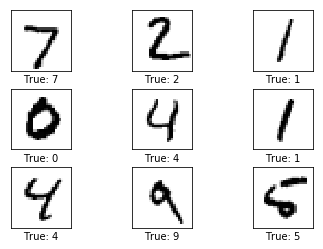

In [18]:
#fetching images from test data sets
images = data.x_test[0:9]
cls_true = data.y_test_cls[0:9]
plot_images(images = images, cls_true = cls_true)

In [19]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev = 0.05))

In [20]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape = [length]))

In [21]:
def new_conv_layer(input, num_input_channels, filter_size, 
                  num_filters, use_pooling = True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape = shape)
    biases = new_biases(length = num_filters)
    layer = tf.nn.conv2d(input = input,
                        filter = weights,
                        strides = [1,1,1,1],
                        padding = 'SAME')
    
    layer += biases
    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                              ksize = [1,2,2,1],
                              strides = [1,2,2,1],
                              padding = 'SAME')
        
    #Rectified Linear Unit
    
    layer = tf.nn.relu(layer)
    return layer, weights

In [22]:
def flatten_layer(layer):
    #to get the shape of input layer
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features
    

In [23]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu = True):
    weights  = new_weights(shape = [num_inputs, num_outputs])
    biases = new_biases(length = num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

In [24]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')


In [25]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [26]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [27]:
y_true_cls = tf.argmax(y_true, axis=1)

In [28]:
#Convolutional Layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer(input = x_image,
                  num_input_channels = num_channels,
                  filter_size = filterSize1,
                  num_filters = numFilter1,
                  use_pooling = True)

Instructions for updating:
Colocations handled automatically by placer.


In [29]:
layer_conv1


<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [30]:
weights_conv1

<tf.Variable 'Variable:0' shape=(5, 5, 1, 16) dtype=float32_ref>

In [31]:
#Convolutional Layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer(input = layer_conv1,
                   num_input_channels = numFilter1,
                   filter_size = filterSize2,
                   num_filters = numFilter2,
                   use_pooling = True)

In [32]:
layer_conv2


<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [33]:
weights_conv2

<tf.Variable 'Variable_2:0' shape=(5, 5, 16, 36) dtype=float32_ref>

In [34]:
#Making a Flatten Layer

layer_flat, num_features = flatten_layer(layer_conv2)

In [35]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [36]:
num_features

1764

In [37]:
#Making a Fully Connected Layer -1
layer_fc1 = new_fc_layer(input = layer_flat,
                        num_inputs = num_features,
                        num_outputs = fc_size,
                        use_relu = True)

In [38]:
layer_fc1


<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [39]:
#Making a Fully Connected Layer - 2
layer_fc2 = new_fc_layer(input = layer_fc1,
                        num_inputs = fc_size,
                         num_outputs = num_classes,
                         use_relu = False)

In [40]:
layer_fc2


<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [41]:
y_pred = tf.nn.softmax(layer_fc2)

In [42]:
y_pred

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>

In [43]:
y_pred_cls = tf.argmax(y_pred, axis = 1)

In [44]:
y_pred_cls 

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

In [45]:
#optimizing the cost function
#the goal is to reduce the cross entropy and make it as close to 0 by changing the variable of the network.

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc2, labels = y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [46]:
cost = tf.reduce_mean(cross_entropy)

In [47]:
#now the we have the cost and we have to minimize the cost to optimize the model. 
# I will use AdamOptimizer which is an advance form of Gradient descent.

optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cost)

In [48]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [49]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [50]:
#Running the TensorFlow
#First of all creating a session

session = tf.Session()


In [51]:
#declaring the variables for weights and biases before we optimize them

session.run(tf.global_variables_initializer())

In [52]:
train_batch_size = 64

In [63]:
total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations+num_iterations):
        #x_batch holds batch of images and y_true_batch holds the true labels for those images.
        x_batch, y_true_batch, _=data.random_batch(batch_size = train_batch_size)
        feed_dict_train = {x : x_batch, y_true : y_true_batch}
        session.run(optimizer, feed_dict = feed_dict_train)
        
        if i%100 == 0:
            acc = session.run(accuracy, feed_dict = feed_dict_train)
            msg = "Optimization Iteration : {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i+1, acc))
            
    total_iterations += num_iterations
    end_time = time.time()
    time_diff = end_time - start_time
    print("Time Usage:" + str(timedelta(seconds = int(round(time_diff)))))

In [68]:
#cls_pred is an array of the predicted class-number for all images in the test-data
#correct is a boolean array whether the predicted class is equal to the true class for each image in the test-set.
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    #getting images from test-dataset that have been classified incorrectly.
    images = data.x_test[incorrect]
    #get the predicted classes for those images
    cls_pred = cls_pred[incorrect]
    #get the true classes for those images
    cls_true = data.y_test_cls[incorrect]
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])
    

In [55]:
#function to plot confusion matrix

def plot_confusion_matrix(cls_pred):
    #getting the true classification for the test set.
    cls_true = data.y_test_cls
    cm = confusion_matrix(y_true = cls_true,
                         y_pred = cls_pred)
    print(cm)
    plt.matshow(cm) #show confusion matrix as an image
    plt.colorbar() #some adjustments to the plot
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    

In [60]:
#function for showing the performance of the model

test_batch_size = 256

def print_test_accuracy(show_example_errors = False,
                       show_confusion_matrix = False):
    num_test = data.num_test
    #allocating an array for the predicted classes which will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape = num_test, dtype = np.int)
    
    #now calculating the predicted classes for the batches.
    
    i = 0
    while i<num_test:
        j = min(i + test_batch_size, num_test)
        #getting the images from the test-set between index i and j.
        images = data.x_test[i:j, :]
        #getting the associated labels:
        labels = data.y_test[i:j, :]
        #create a feed-dict with these images and labels
        feed_dict = {x:images,
                    y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict = feed_dict)
        
        #set the start index of the next batch to the end index of the current batch.
        
        i = j
    cls_true = data.y_test_cls
    
    correct = (cls_true == cls_pred)
    
    #calculating the number of correctly classified images.while summing the boolean array 0 mean false and 1 means true
    correct_sum = correct.sum()
    
    #classification accuracy is the number of correctly classified images divided by the total number of images in the test set.
    acc = float(correct_sum) / num_test
    
    msg = "Accuracy on Test-set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred = cls_pred, correct = correct)
        
    
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred = cls_pred)
    
        

In [61]:
#let's check the test accuracy without optimizing. Pretty sure that the accuracy will be very low.

print_test_accuracy()


Accuracy on Test-set: 13.8% (1379 / 10000)


In [64]:
#Now let's check with one optimization iteration

optimize(num_iterations = 1)

Optimization Iteration :      1, Training Accuracy:  20.3%
Time Usage:0:00:01


In [65]:
print_test_accuracy()

Accuracy on Test-set: 14.5% (1453 / 10000)


In [66]:
#Now lets check with 100 optimization iterations

optimize(num_iterations = 99)

Time Usage:0:00:10


Accuracy on Test-set: 60.8% (6081 / 10000)
Example errors:


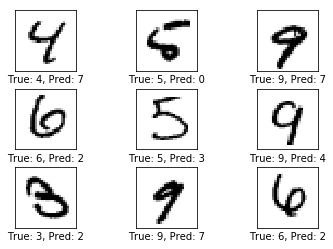

In [69]:
print_test_accuracy(show_example_errors = True)

In [70]:
#lets try with 1000 optimization iterations

optimize(num_iterations = 900)

Optimization Iteration :    101, Training Accuracy:  64.1%
Optimization Iteration :    201, Training Accuracy:  85.9%
Optimization Iteration :    301, Training Accuracy:  81.2%
Optimization Iteration :    401, Training Accuracy:  85.9%
Optimization Iteration :    501, Training Accuracy:  96.9%
Optimization Iteration :    601, Training Accuracy:  93.8%
Optimization Iteration :    701, Training Accuracy:  87.5%
Optimization Iteration :    801, Training Accuracy:  87.5%
Optimization Iteration :    901, Training Accuracy:  82.8%
Time Usage:0:01:13


Accuracy on Test-set: 93.2% (9315 / 10000)
Example errors:


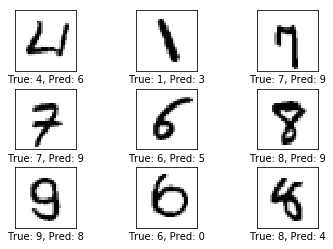

In [71]:
print_test_accuracy(show_example_errors = True)

In [72]:
#running 10000 optimization iterations

optimize(num_iterations = 9000)

Optimization Iteration :   1001, Training Accuracy:  90.6%
Optimization Iteration :   1101, Training Accuracy:  93.8%
Optimization Iteration :   1201, Training Accuracy:  98.4%
Optimization Iteration :   1301, Training Accuracy:  93.8%
Optimization Iteration :   1401, Training Accuracy:  96.9%
Optimization Iteration :   1501, Training Accuracy:  92.2%
Optimization Iteration :   1601, Training Accuracy:  98.4%
Optimization Iteration :   1701, Training Accuracy:  90.6%
Optimization Iteration :   1801, Training Accuracy:  95.3%
Optimization Iteration :   1901, Training Accuracy:  93.8%
Optimization Iteration :   2001, Training Accuracy:  95.3%
Optimization Iteration :   2101, Training Accuracy:  98.4%
Optimization Iteration :   2201, Training Accuracy:  98.4%
Optimization Iteration :   2301, Training Accuracy:  98.4%
Optimization Iteration :   2401, Training Accuracy:  93.8%
Optimization Iteration :   2501, Training Accuracy:  93.8%
Optimization Iteration :   2601, Training Accuracy:  95.

Accuracy on Test-set: 98.7% (9873 / 10000)
Example errors:


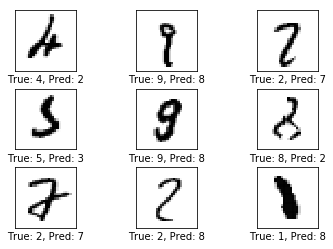

Confusion Matrix:
[[ 976    0    0    0    0    0    3    1    0    0]
 [   0 1129    1    0    1    0    2    1    1    0]
 [   2    4 1010    2    1    0    0    5    8    0]
 [   1    0    0 1002    0    4    0    1    2    0]
 [   0    2    1    0  977    0    1    1    0    0]
 [   2    1    0    3    0  884    2    0    0    0]
 [   3    3    0    0    4    6  942    0    0    0]
 [   0    3    6    2    0    0    0 1014    1    2]
 [   3    1    1    2    1    1    0    2  963    0]
 [   4    5    0    1    9    3    0    5    6  976]]


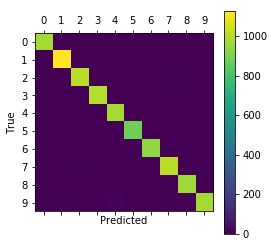

In [73]:
print_test_accuracy(show_example_errors = True,
                   show_confusion_matrix = True)